In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import wget
import requests
import netCDF4 as nc4
from multiprocessing.pool import ThreadPool
import requests

In [2]:
#read the subset txt
urls = pd.read_csv("D:\\GU\\IC\\Veranico\\daily_datasets\\gpcp.txt", sep=" ", header=None)
# transform to string
urls = urls.astype(str).rename(columns={0:"url"})
#exclude first 2 lines
urls = urls[2:]
#folder_path = r"E:\Veranico_HD\raw_datasets\imerg"
folder_path = r"E:\Veranico_HD\raw_datasets\gpcp"
##urls to dataframe
urls['files_names'] = [url.split("_")[-2]+'.nc4' for url in urls.url]
#list of all files inside folder_path
files = os.listdir(folder_path)
#exclude from urls the files that are already downloaded
urls = urls[~urls.files_names.isin(files)]


In [3]:
#list of all files inside folder_path
files = os.listdir(folder_path)
#exclude from urls the files that are already downloaded
urls = urls[~urls.files_names.isin(files)]

MAX_THREADS = 100  # <--- tweak this

urls_list = urls.url.values

def download(url):
    r = requests.get(url)
    FILENAME = os.path.join(folder_path, url.split("_")[-2]+'.nc4')
    try:
        r.raise_for_status()
        f = open(FILENAME,'wb')
        f.write(r.content)
        f.close()
        print("Downloaded " + url.split("_")[-2])

    except:
        print('requests.get() returned an error code '+str(r.status_code))

if __name__ == "__main__":
    with ThreadPool(MAX_THREADS) as p:
        p.map(download, urls_list)

requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error code 503
requests.get() returned an error c

# clean

In [9]:
lat_min = -25
lat_max = -2
lon_min = -61
lon_max = -42
date_start= '1981-01-01'
date_end = '2020-12-31'
dataset = 'gpcp'
# Specify the path to the folder containing the NetCDF files
folder_path = r"E:\Veranico_HD\raw_datasets\\" + dataset
# Open and concatenate all the NetCDF files
ds = xr.open_mfdataset(os.path.join(folder_path, '*.nc4'),combine='nested', concat_dim='time')


In [10]:
ds = ds.rename({'precip': 'pr'})
ds = ds.sortby(ds.lat)
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice(date_start, date_end))
#ds['pr'] = ds['pr']  * 30 * 24
ds = ds.chunk({'time': -1, 'lat': 10, 'lon': 10})


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [13]:
ds.to_netcdf(r'E:\Veranico_HD\clean_cerrado\\' + dataset + '.nc')


In [14]:
ds

<xarray.Dataset>
Dimensions:  (lon: 38, lat: 46, time: 7305)
Coordinates:
  * lon      (lon) float32 -60.75 -60.25 -59.75 -59.25 ... -43.25 -42.75 -42.25
  * lat      (lat) float32 -24.75 -24.25 -23.75 -23.25 ... -3.25 -2.75 -2.25
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2020-12-31
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(7305, 10, 10), meta=np.ndarray>
Attributes: (12/68)
    ShortName:                      GPCPDAY
    LongName:                       GPCP Precipitation Level 3 Daily 0.5-Degr...
    VersionID:                      3.2
    GranuleID:                      GPCPDAY_L3_20010101_V3.2.nc4
    Format:                         NetCDF-4
    RangeBeginningDate:             2001-01-01
    ...                             ...
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    Fees:                           None
    ProcessingLevel:                Level 3
    Institution:                    Mesoscale Atmospheric Processes Laborator...
    Comment:                        The GPCP V3.2 Daily is being developed in...
    history:                        2023-12-18 17:36:31 GMT hyrax-1.16.4 http...

In [15]:
# CDD
from funcs import *
ds = xr.open_dataset(r'E:\\Veranico_HD\\clean_cerrado\\' + dataset + '.nc')
cdd = cdd_numba(ds.pr)
cdd.to_netcdf(r"D:\GU\IC\Veranico\daily_datasets\CDD\\" + dataset + '.nc')

d:\GU\IC\Veranico\funcs.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  daa = xr.apply_ufunc(


In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [17]:
regions = gpd.read_file(r"D:\GU\IC\Scripts\Data\regions1.geojson")
mm = cdd.where(cdd > 5).mean(dim='time')


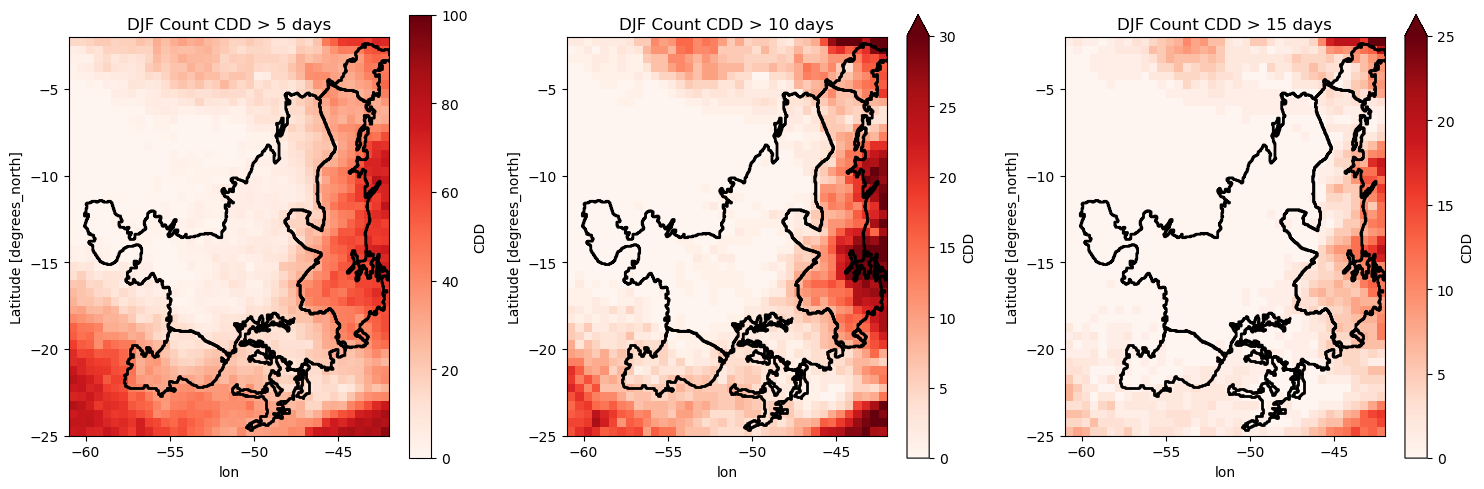

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
cdd.sel(time=cdd['time.season'] == 'DJF').where(cdd > 5).count(dim='time').plot(ax=axs[0],  cmap='Reds', vmax=100)
cdd.sel(time=cdd['time.season'] == 'DJF').where(cdd > 10).count(dim='time').plot(ax=axs[1], cmap='Reds', vmax=30)
cdd.sel(time=cdd['time.season'] == 'DJF').where(cdd > 15).count(dim='time').plot(ax=axs[2], cmap='Reds', vmax=25)
for i in range(3):
    axs[i].set_title('DJF Count CDD > ' + str([5, 10, 15][i]) + ' days')
    regions.plot(ax=axs[i], color='none', edgecolor='black', linewidth=2)

plt.tight_layout()